In [1]:
import os
#import pickle as pkl

#import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [3]:
NTRY = 14
#NAME = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose'
NAME_CB  = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose'
NAME_XGB = f'{NTRY}_xgb_pca64_sber_lags_parse_bord_nose'
NAME_LGB = f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose'

# Конкатенация

In [4]:
subm_views = pd.read_csv(os.path.join(DIR_SUBM, f'1_xgb_baseline_test.csv'),  usecols=['document_id', 'views'])
subm_depth = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose.csv'), usecols=['document_id', 'depth'])
subm_frp   = pd.read_csv(os.path.join(DIR_SUBM, f'{NTRY}_lgb_pca64_sber_lags_parse_bord_nose.csv'), usecols=['document_id', 'full_reads_percent'])
print(subm_views.shape, subm_depth.shape, subm_frp.shape)

(3000, 2) (3000, 2) (3000, 2)


In [5]:
subm = subm_views.merge(subm_depth, on='document_id', validate='one_to_one')
#subm = subm.merge(subm_depth, on='document_id', validate='one_to_one')
subm = subm.merge(subm_frp, on='document_id', validate='one_to_one')

In [6]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_concatenate.csv'), index = False)

# Ансамбли

In [7]:
train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), usecols = ['document_id', 'views', 'depth', 'full_reads_percent'])
val  = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), usecols = ['document_id', 'views', 'depth', 'full_reads_percent'])

cb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_CB}_train_part.csv'))
cb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_CB}_val_part.csv'))

xgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_XGB}_train_part.csv'))
xgb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_XGB}_val_part.csv'))

lgb_train = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_LGB}_train_part.csv'))
lgb_val = pd.read_csv(os.path.join(DIR_SUBM_PART, f'{NAME_LGB}_val_part.csv'))

In [8]:
print('before ', cb_train.shape, lgb_train.shape, xgb_train.shape)
print('before ', cb_val.shape, lgb_val.shape, xgb_val.shape)
train = pd.concat([train.reset_index(drop = True),
                   cb_train.reset_index(drop = True),
                   xgb_train.reset_index(drop = True),
                   lgb_train.reset_index(drop = True),
                  ], ignore_index = True, axis = 1)

val = pd.concat([val.reset_index(drop = True),
                 cb_val.reset_index(drop = True),
                 xgb_val.reset_index(drop = True),
                 lgb_val.reset_index(drop = True),
                ], ignore_index = True, axis = 1)

cols = ['document_id', 'views', 'depth', 'full_reads_percent',
         'document_id_cb', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb',
         'document_id_xgb', 'views_pred_xgb', 'depth_pred_xgb', 'frp_pred_xgb',
         'document_id_lgb', 'views_pred_lgb', 'depth_pred_lgb', 'frp_pred_lgb',
        ]
train.columns = cols
val.columns = cols

if sum(train.document_id == train.document_id_xgb) != train.shape[0] or \
   sum(train.document_id == train.document_id_lgb) != train.shape[0]:
    print('wtf train')
    
if sum(val.document_id == val.document_id_xgb) != val.shape[0] or \
   sum(val.document_id == val.document_id_lgb) != val.shape[0]:
    print('wtf val')

train.drop(['document_id_xgb', 'document_id_xgb'], axis = 1, inplace = True)
val.drop(['document_id_xgb', 'document_id_xgb'], axis = 1, inplace = True)
    
    
print('after ', train.shape)
print('after ', val.shape)

before  (5584, 4) (5584, 4) (5584, 4)
before  (1397, 4) (1397, 4) (1397, 4)
after  (5584, 15)
after  (1397, 15)


In [9]:
val.columns

Index(['document_id', 'views', 'depth', 'full_reads_percent', 'document_id_cb',
       'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb', 'views_pred_xgb',
       'depth_pred_xgb', 'frp_pred_xgb', 'document_id_lgb', 'views_pred_lgb',
       'depth_pred_lgb', 'frp_pred_lgb'],
      dtype='object')

In [10]:
def plot_corrc(inp_df, inp_cols, targ_cols = ['views', 'depth', 'full_reads_percent']):
    f, ax = plt.subplots(1, 2, figsize=(24, 8))
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(), 
    #sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[0])
    sns.heatmap(inp_df[inp_cols + targ_cols].corr(method = 'spearman'), 
    #sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(), 
                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1])
#    sns.heatmap(inp_df.query('c2 == 0')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 0])
#    sns.heatmap(inp_df.query('c2 == 1')[inp_cols + targ_cols].corr(method = 'spearman'), 
#                annot = True, cmap= 'coolwarm', linewidths=3, linecolor='black', ax = ax[1, 1])
    
    sns.pairplot(inp_df[inp_cols + targ_cols], height = 16,) #hue = 'c2')

In [11]:
#plot_corrc(train, ['views'], ['views_pred_cb'])
#plot_corrc(train, ['views'], ['views_pred_xgb'])
#plot_corrc(train, ['views'], ['views_pred_lgb'])

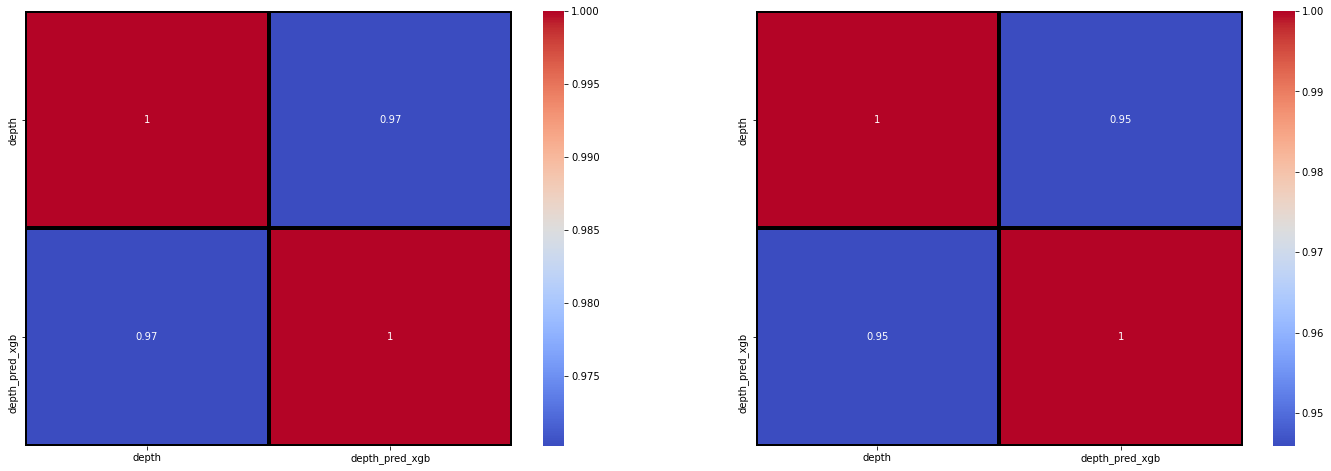

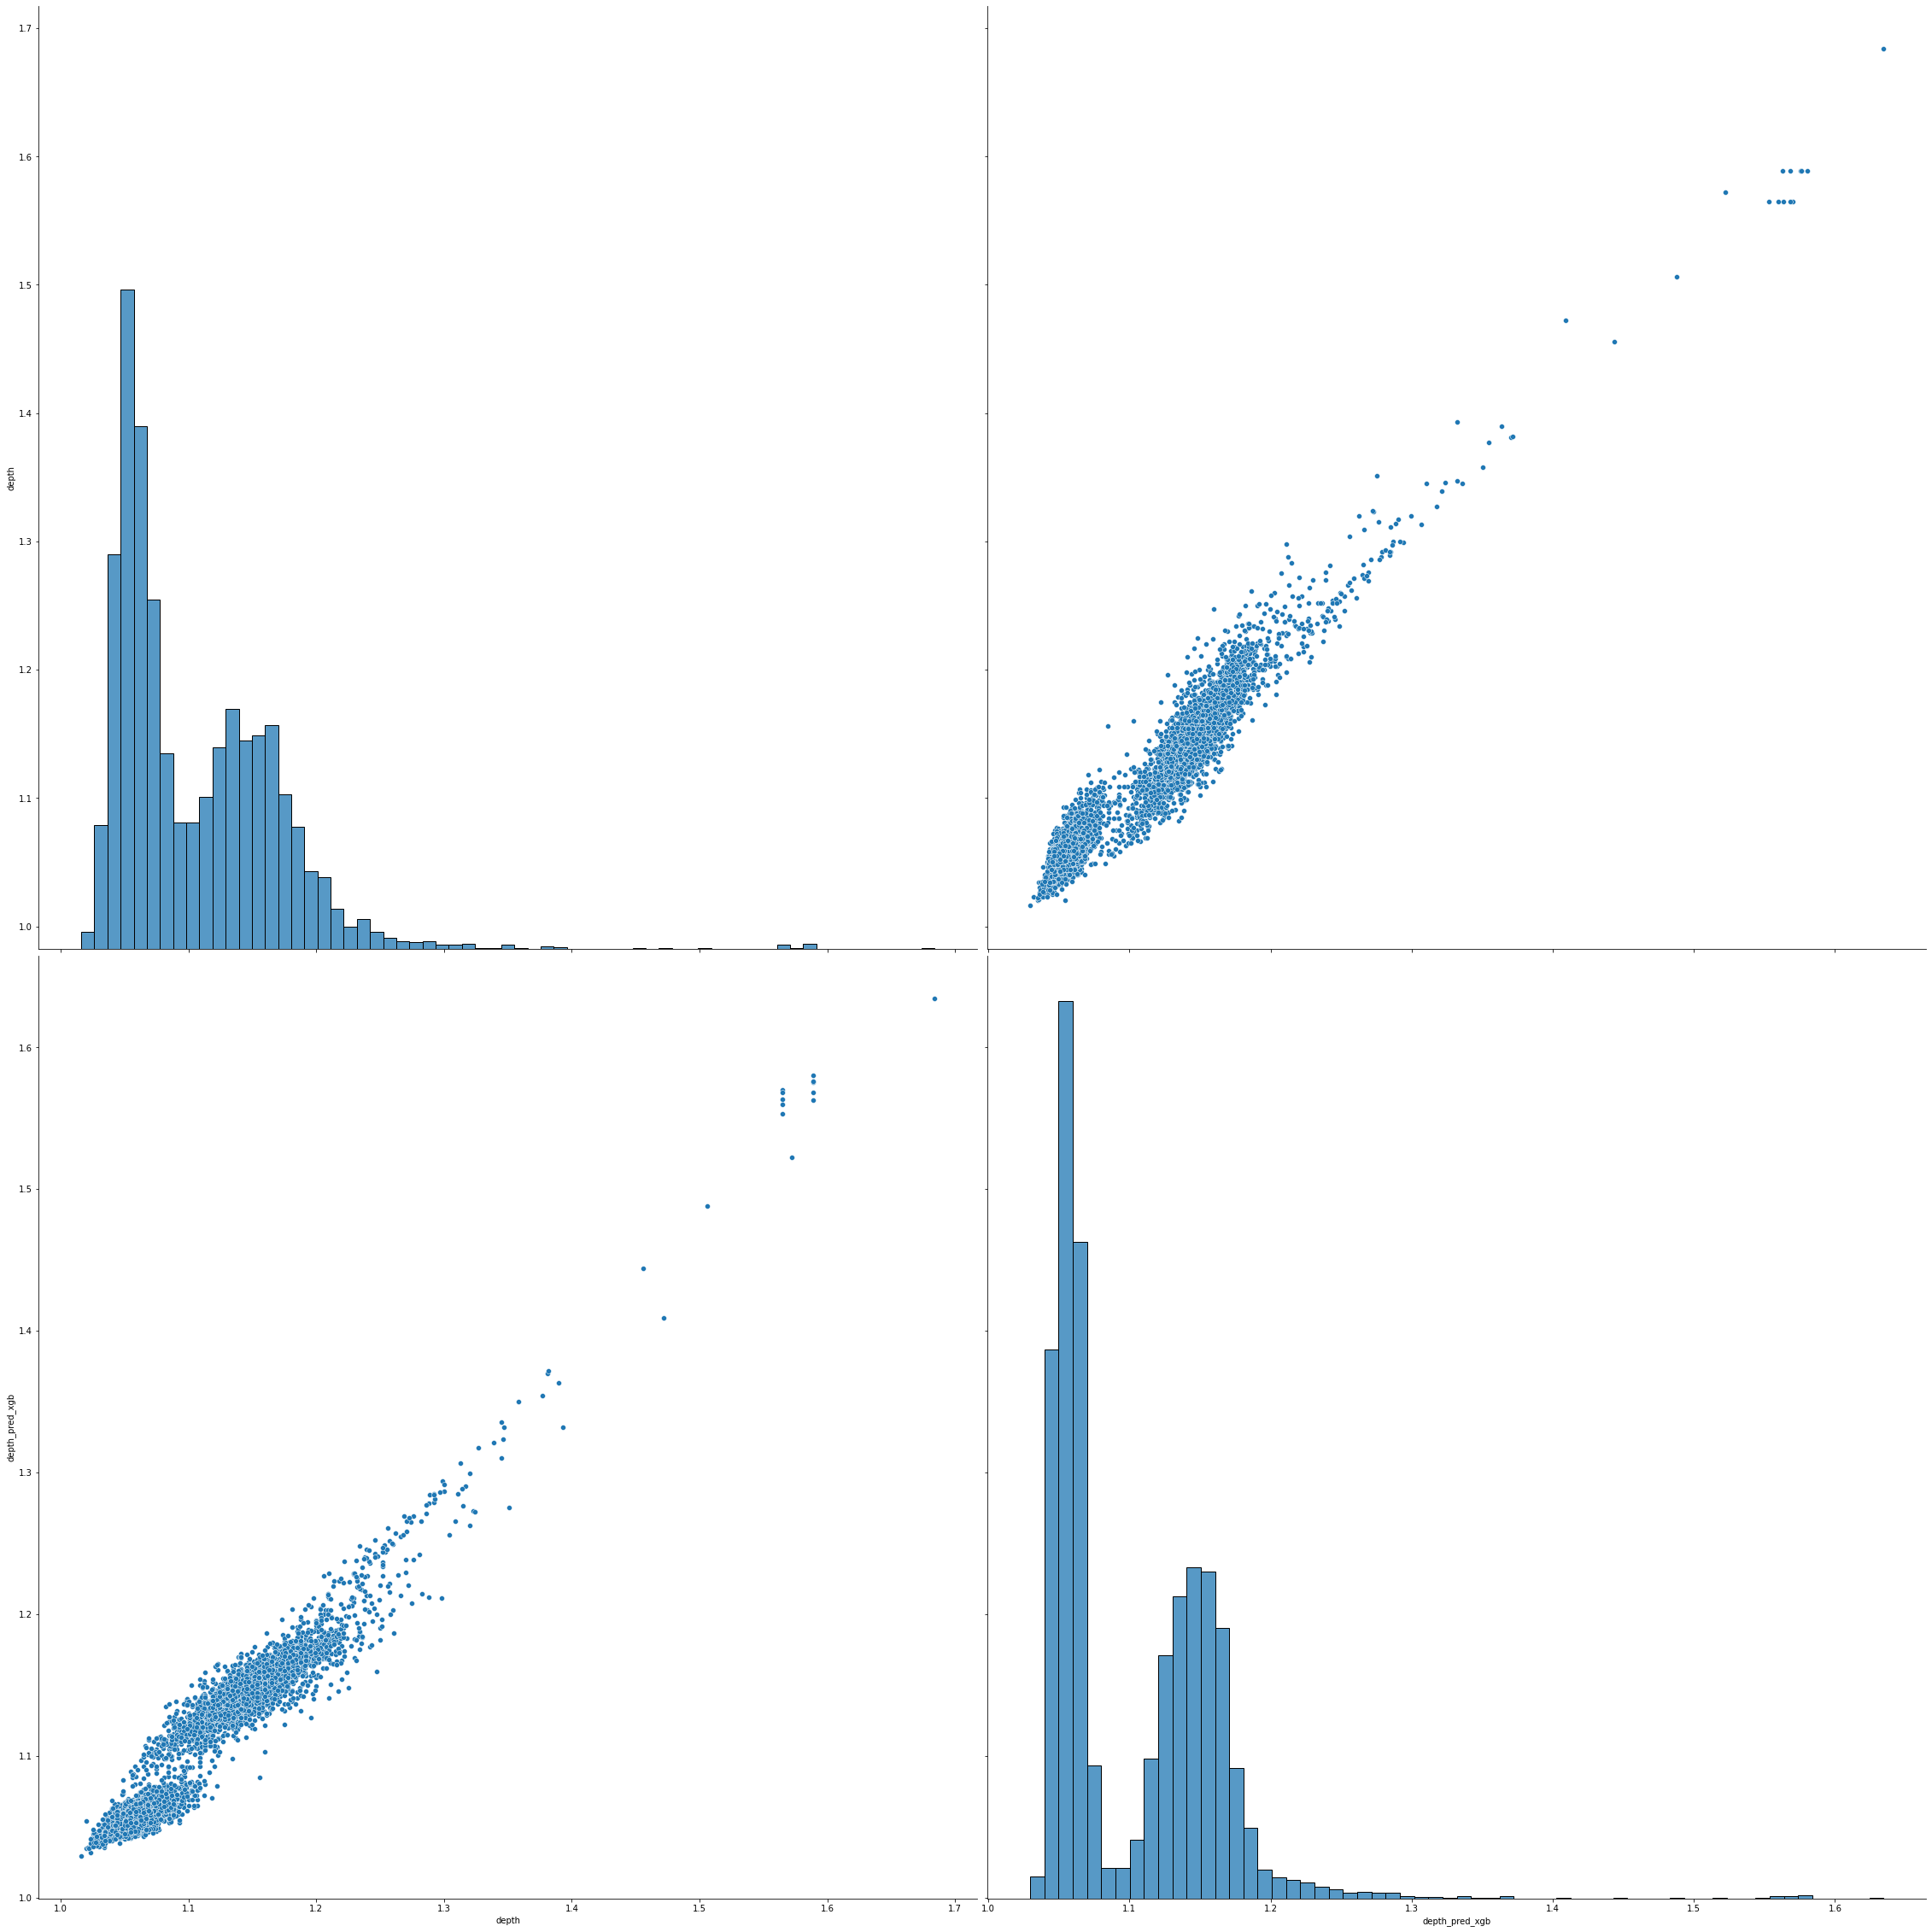

In [12]:
#plot_corrc(train, ['depth'], ['depth_pred_cb'])
plot_corrc(train, ['depth'], ['depth_pred_xgb'])
#plot_corrc(train, ['depth'], ['depth_pred_lgb'])